In [1]:
from SOC_func_scaler import *
import matplotlib.pyplot as pl
from keras import models, layers
import tensorflow as tf
from keras.callbacks import ModelCheckpoint
from keras.callbacks import TensorBoard
import datetime
import os

%load_ext tensorboard

In [2]:
VERSION = 'SOC_CNN-LSTM'

FILE_00 = '180801_RFB_510cy_006_DC.csv'
FILE_01 = None
FILE_02 = None
FILE_03 = None
FILE_04 = None
FILE_05 = None
FILE_06 = None

In [3]:
drop_labels_x = ['시험_시간(s)', '사이클_번호', '사이클_시간(s)', '단계_번호', '단계_시간(s)', '인덱스', '보조전압1(V)', '보조전압2(V)', '보조전압3(V)', '온도(\'C)', '전류_범위', 'OCP(V)', '파워(W)', '부하(Ohm)', '누적_용량(Ah)', '절대값_용량(Ah)']
drop_labels_y = ['시험_시간(s)', '사이클_번호', '사이클_시간(s)', '단계_번호', '단계_시간(s)', '인덱스', '보조전압1(V)', '보조전압2(V)', '보조전압3(V)', '온도(\'C)', '전류_범위', 'OCP(V)', '전류(A)', '파워(W)', '부하(Ohm)', '누적_용량(Ah)', '절대값_용량(Ah)']

param = {'seq_len' : 200, 'num_units' : 64, 'num_filters' : 64, 'window' : 3, 'dropout': 0.1, 'num_epochs' : 500, 'num_dense': 16}

log_dir = f"logs/{VERSION}/" + datetime.datetime.now().strftime("%Y%m%d-%H%M") + f'-{param["num_filters"]}FL-{param["num_units"]}UN-{param["num_epochs"]}EP-{param["seq_len"]}SQ'
file_path = f'Checkpoints\{VERSION}\SOH_Checkpoint\{param["num_filters"]}FL-{param["num_units"]}UN-{param["num_epochs"]}EP-{param["seq_len"]}SQ.h5'
hist_freq = 25

save_path = f'outputs\{VERSION}\{param["num_filters"]}FL-{param["num_units"]}UN-{param["num_epochs"]}EP-{param["seq_len"]}SQ'
try:
    if not os.path.exists(save_path):
        os.makedirs(save_path)
except OSError:
    print('Error Creating Directory...')

Index(['전류(A)', '전압(V)'], dtype='object')
Index(['전압(V)'], dtype='object')
180801_RFB_510cy_006_DC.csv => (262372, 2)


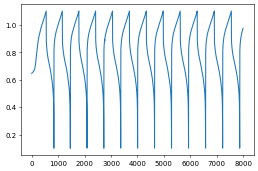

In [4]:
data00, data_cap00 = get_data(FILE_00, drop_labels_x, drop_labels_y)

In [5]:
x_train00 = seq_gen_x(data00, param['seq_len'])
y_train00 = seq_gen_y(data_cap00, param['seq_len'])
x_train00, y_train00, x_test, y_test = split_data(x_train00, y_train00)
print(x_train00.shape)
print(y_train00.shape)
print(x_train00[0:5, -1, 1])
print(y_train00[:4])

split_len = 183520
x_train = (262172, 200, 2)
y_train = (262172, 1, 1)
(262172, 200, 2)
(262172, 1, 1)
[0.81069183 0.81256163 0.8144314  0.81596124 0.81766105]
[[[0.81256163]]

 [[0.8144314 ]]

 [[0.81596124]]

 [[0.81766105]]]


In [6]:
inputs = layers.Input(shape=(None, x_train00.shape[-1]), name = 'Inputs')
x1 = layers.Conv1D(param['num_filters'], param['window'], padding='causal', name = 'Conv. 1D')(inputs)
x2 = layers.LSTM(param['num_units'], return_sequences = True, name = 'LSTM_sequence')(inputs)
x = layers.concatenate([x1, x2])
x = layers.LSTM(16)(x, name = 'LSTM_concatenate')
x = layers.Dropout(param['dropout'], name = 'Dropout')(x)
outputs = layers.Dense(1, name = 'Outputs')(x)
model = models.Model(inputs = inputs, outputs = outputs, name = 'CNN_LSTM_PARALLEL')
model.compile(loss = 'mse', optimizer = 'Adam')
model.summary()

Model: "CNN_LSTM_PARALLEL"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Inputs (InputLayer)            [(None, None, 2)]    0           []                               
                                                                                                  
 conv1d (Conv1D)                (None, None, 64)     448         ['Inputs[0][0]']                 
                                                                                                  
 lstm (LSTM)                    (None, None, 64)     17152       ['Inputs[0][0]']                 
                                                                                                  
 concatenate (Concatenate)      (None, None, 128)    0           ['conv1d[0][0]',                 
                                                                  'lstm[0][0]']   

In [7]:
BATCH_SIZE = 2000
callback_list = [ModelCheckpoint(filepath = file_path, monitor = 'val_loss', save_best_only = True),
                 TensorBoard(log_dir=log_dir, histogram_freq=hist_freq)]
fitdata = model.fit(x_train00, y_train00, epochs=param['num_epochs'], verbose = 1, batch_size=BATCH_SIZE, validation_split=0.2, callbacks=callback_list)

Epoch 1/500
105/105 [==============================] - 12s 75ms/step - loss: 0.0219 - val_loss: 0.0040
Epoch 2/500
105/105 [==============================] - 7s 68ms/step - loss: 0.0088 - val_loss: 0.0029
Epoch 3/500
105/105 [==============================] - 7s 68ms/step - loss: 0.0068 - val_loss: 0.0023
Epoch 4/500
105/105 [==============================] - 7s 68ms/step - loss: 0.0062 - val_loss: 0.0020
Epoch 5/500
105/105 [==============================] - 7s 68ms/step - loss: 0.0058 - val_loss: 0.0017
Epoch 6/500
105/105 [==============================] - 7s 69ms/step - loss: 0.0055 - val_loss: 0.0016
Epoch 7/500
105/105 [==============================] - 7s 68ms/step - loss: 0.0053 - val_loss: 0.0014
Epoch 8/500
105/105 [==============================] - 7s 69ms/step - loss: 0.0050 - val_loss: 0.0014
Epoch 9/500
105/105 [==============================] - 7s 69ms/step - loss: 0.0047 - val_loss: 0.0013
Epoch 10/500
105/105 [==============================] - 7s 69ms/step - loss: 0.00

16/16 [==============================] - 0s 7ms/step
(495, 1)
outputs\Scaler_Parallel_Dropout0.1_Dense\64FL-64UN-2000EP-20SQ


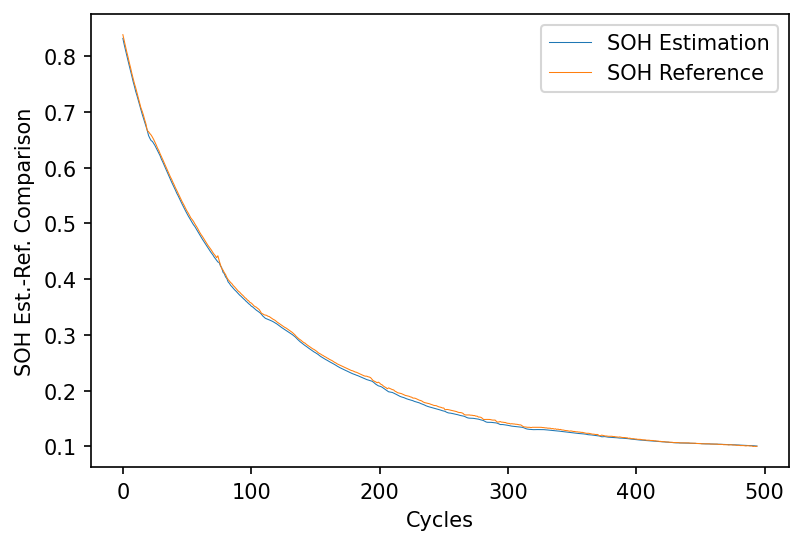

In [ ]:
RMSE, MAE, Error_rate = show_and_prove(model, file_path, x_test, y_test, save_path, return_loss=True)

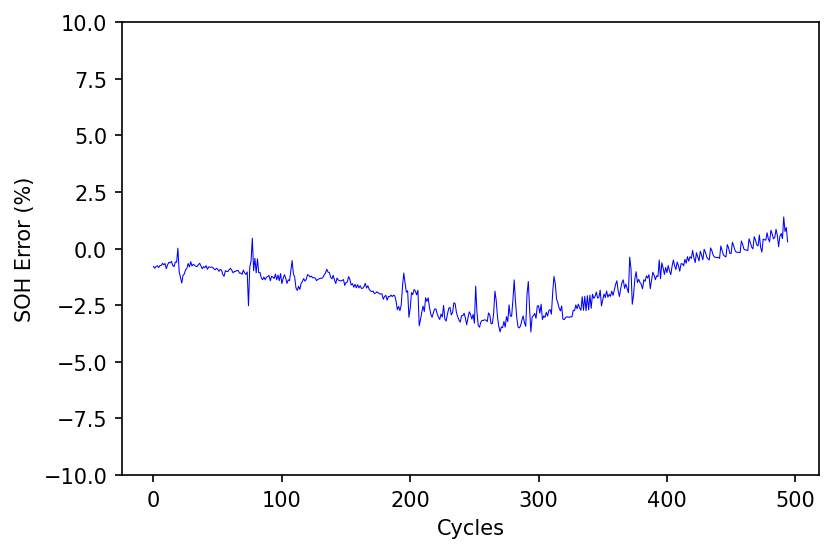

RMSE(0.003985), MAE(0.003478)


In [ ]:
pl.figure(dpi=150)
line = pl.plot(Error_rate)
pl.ylim(-10, 10)
pl.ylabel('SOC Error (%)')
pl.xlabel('Cycles')
pl.setp(line, color='b', linewidth=0.5)
pl.savefig(f'{save_path}\\ErrRate-RMSE({RMSE:.4f})MAE({MAE:.4f}).png')
pl.show()
print(f'RMSE({RMSE:.6f}), MAE({MAE:.6f})')